In [1]:
import numpy as np
import pandas as pd
import os
import pickle
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold
import seaborn as sns
from utils import *

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
data = pd.read_csv('trial_data_distances.csv')

In [3]:
data

,participant_id,Trial,Jitter,Condition,answ,correct,rt,"Dist to A1, LH","Dist to A1, RH","Dist to V1, LH","Dist to V1, RH",dist_ratio_L,dist_ratio_R,sex,age,FlashType,NrBeeps
0,51902,1,1050,8,2,1,0.77143,29.954478,43.595286,88.374344,83.440799,0.338950,0.522470,1,22.4,3,1
1,51902,1,1050,8,2,1,0.77143,29.954478,43.595286,88.374344,83.440799,0.338950,0.522470,1,22.4,3,1
2,51902,1,1050,8,2,1,0.77143,29.954478,43.595286,88.374344,83.440799,0.338950,0.522470,1,22.4,3,1
3,51902,1,1050,8,2,1,0.77143,29.954478,43.595286,88.374344,83.440799,0.338950,0.522470,1,22.4,3,1
4,51902,1,1050,8,2,1,0.77143,29.954478,43.595286,88.374344,83.440799,0.338950,0.522470,1,22.4,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743035,42017,360,1050,4,1,1,0.50356,59.870638,44.819962,85.135305,76.978316,0.703241,0.582241,1,20.3,2,0
743036,42017,360,1050,4,1,1,0.50356,59.870638,44.819962,85.135305,76.978316,0.703241,0.582241,1,20.3,2,0
743037,42017,360,1050,4,1,1,0.50356,59.870638,44.819962,85.135305,76.978316,0.703241,0.582241,1,20.3,2,0
743038,42017,360,1050,4,1,1,0.50356,59.870638,44.819962,85.135305,76.978316,0.703241,0.582241,1,20.3,2,0


In [4]:
data = data[(data["FlashType"] == 1) | (data["FlashType"] == 2)]

<Axes: xlabel='correct', ylabel='Count'>

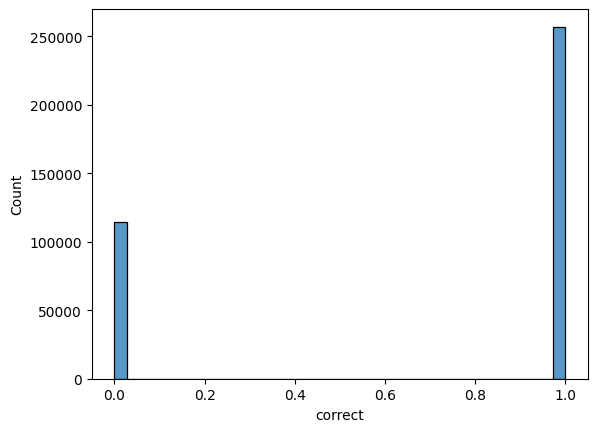

In [5]:
sns.histplot(data["correct"])

In [6]:
correct = data["correct"]

In [7]:
data = data.drop(["participant_id","correct", "answ", "rt", "Dist to V1, RH", "Dist to A1, RH", "dist_ratio_R", "dist_ratio_L", "Condition"], axis=1, index=None) # "Dist to V1, RH", "Dist to A1, RH", "Dist to A1, LH", "dist_ratio_R", "dist_ratio_L"

## Pipeline

In [8]:
num_features = ["Jitter", "Dist to A1, LH", "Dist to V1, LH", "age"]
# ord_features = [data_flash1.columns[0]]
cat_features = ["sex", "FlashType", "NrBeeps"]
ord_features = ["Trial"]



In [9]:
whiten = Pipeline(
    steps = [("whiten", StandardScaler())]
)

cat_encoder = Pipeline(
    steps = [("cat_encoder", OneHotEncoder(handle_unknown="ignore"))]
)

ord_encoder = Pipeline(
    steps = [("cat_encoder", OrdinalEncoder())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("whiten", whiten, num_features),
        ("ord_encoder", ord_encoder, ord_features),
        ("cat_encoder", cat_encoder, cat_features)
    ]
)

In [11]:
from sklearn import svm
svm = svm.SVC(kernel = "linear")
svm_pipe = Pipeline([('preprocessor', preprocessor),
                ('svm',svm)])

## 10-fold Cross-validation

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data, correct, test_size=0.25, random_state=42)

In [13]:
cat_feature_names = ["sex_0", "sex_1", "FlashType_1", "FlashType_2", "NrBeeps_0", "NrBeeps_1", "NrBeeps_2"]
feature_names = ord_features + cat_feature_names + num_features

In [70]:
cv = KFold(n_splits = 10, shuffle = True, random_state = 42)
cv_results = cross_validate(svm_pipe, X_train, y_train, cv=cv, scoring=['accuracy', 'f1'], return_estimator =True, n_jobs = -1)

KeyboardInterrupt: 

In [40]:
print("Mean accuracy: ", np.mean(cv_results['test_accuracy']))
print("Mean F1 ", np.mean(cv_results['test_f1']))

Mean accuracy:  nan
Mean F1  nan


In [71]:
feature_names

['Trial',
 'sex_0',
 'sex_1',
 'FlashType_1',
 'FlashType_2',
 'NrBeeps_0',
 'NrBeeps_1',
 'NrBeeps_2',
 'Jitter',
 'Dist to A1, LH',
 'Dist to V1, LH',
 'age']

In [72]:
coefs = pd.DataFrame(
    [
        est[-1].coef_[0] * est[:-1].transform(X_train.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_results["estimator"], cv.split(X_train, y_train))
    ],
    columns = feature_names
)

ValueError: Found unknown categories [1, 4, 6, 8, 9, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360] in column 0 during transform

In [73]:
coefs

,Trial,sex_0,sex_1,FlashType_1,FlashType_2,NrBeeps_0,NrBeeps_1,NrBeeps_2,Jitter,"Dist to A1, LH","Dist to V1, LH",age
0,0.061135,0.048351,0.012919,-0.019045,0.635532,-0.092366,0.092366,0.470337,-0.470337,0.523166,0.829112,-1.351043
1,0.019417,0.102424,0.039998,-0.010977,0.727179,-0.096395,0.096395,0.547707,-0.547707,0.583439,0.902724,-1.485173
2,0.019847,0.041439,0.002539,0.017345,0.665939,-0.098622,0.098622,0.487738,-0.487738,0.534627,0.835937,-1.369239
3,0.043591,0.054318,0.039615,-0.055639,0.635050,-0.073037,0.073037,0.491412,-0.491412,0.548893,0.828033,-1.375128
4,-0.032247,0.084544,0.061037,-0.019124,0.713839,-0.064781,0.064781,0.549476,-0.549476,0.575526,0.906718,-1.480667
5,0.028961,0.041652,0.011819,0.022134,0.642268,-0.075052,0.075052,0.473922,-0.473922,0.558359,0.788755,-1.346643
6,0.092351,0.000934,0.036573,0.050500,0.697910,-0.095426,0.095426,0.501885,-0.501885,0.549010,0.842147,-1.390240
7,0.079690,0.065023,0.060447,-0.005567,0.634686,-0.096440,0.096440,0.499608,-0.499608,0.542753,0.854223,-1.395343
8,0.088352,0.081131,0.020255,-0.006324,0.611765,-0.106380,0.106380,0.472675,-0.472675,0.523053,0.834049,-1.356497
9,0.026497,0.053273,0.047777,0.015912,0.617042,-0.096260,0.096260,0.478966,-0.478966,0.528173,0.835816,-1.362680


In [74]:
coefs= pd.read_csv("cv_coefs.csv")

Text(0.5, 1.0, 'Coefficient importance and its variability')

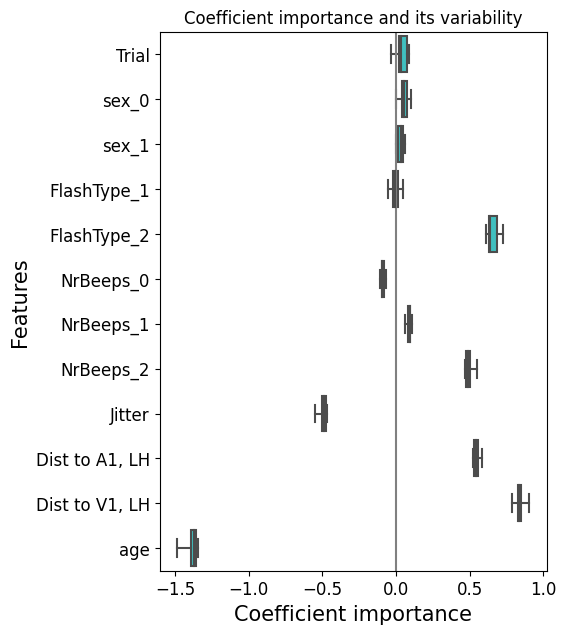

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

fig, ax = plt.subplots(figsize=(5, 7))
sns.boxplot(data=coefs.iloc[:, :100], orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
ax.set_ylabel("Features", fontsize = 15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='x', labelsize= 12) 
ax.tick_params(axis='y', labelsize= 12) 
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")

## Model diagnostics

In [14]:
trained_svm = svm.fit(X_train, y_train)

In [ ]:
y_pred = trained_svm.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

print("Accuracy: {}".format(accuracy_score(y_true=y_train,y_pred=y_pred)))

R squared: 0.6640580752124541


In [ ]:
pred_prob_test = trained_svm.predict_proba(X_test)[:, 1]

In [ ]:
print("AUC: {}".format(roc_auc_score(y_test,pred_prob_test)))

## Permutation feature importance

In [22]:
from sklearn.inspection import permutation_importance

perm_acc = permutation_importance(trained_svm, X_test, y_test,n_repeats=1000, random_state=42, n_jobs = -1)
perm_sorted_idx = perm_acc.importances_mean
perm_std = perm_acc.importances_std
null_dist_coefs = perm_acc.importances

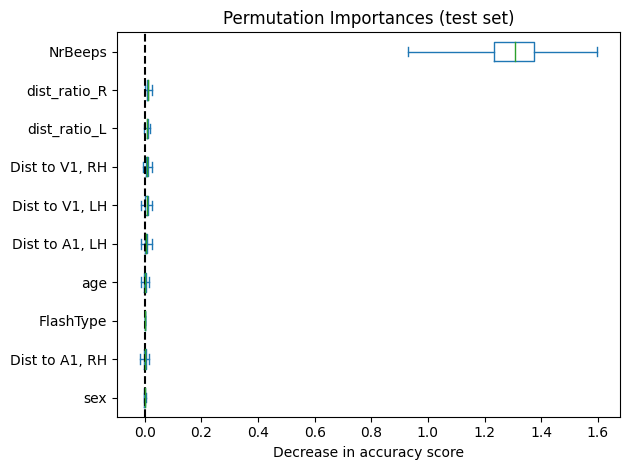

In [23]:
sorted_importances_idx = perm_acc.importances_mean.argsort()
importances = pd.DataFrame(
    perm_acc.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()